# Data Analysis

In [98]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random     as rnd
import sklearn    as skl
import skopt      as sko
import numpy      as np
import pandas     as pd
import seaborn as sns
import keras

2022-05-16 16:48:37.482838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-16 16:48:37.482875: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
df = pd.read_hdf('data/cicy3o.h5')

In [10]:
df.describe()

,euler,h11,h21,num_cp,num_eqs,min_dim_cp,max_dim_cp,mean_dim_cp,median_dim_cp,num_cp_1,...,num_over,num_ex,min_deg_eqs,max_deg_eqs,mean_deg_eqs,median_deg_eqs,rank_matrix,norm_matrix,isprod,favour
count,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,...,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.0
mean,-42.649937,7.419772,28.744740,6.540684,7.301648,1.020152,2.708999,1.616977,1.409252,3.572750,...,3.760963,2.239037,2.027503,3.277186,2.378916,2.172687,6.216857,4.242878,0.002788,0.0
std,20.589891,2.250891,8.577282,1.596812,2.087152,0.184930,0.791630,0.296287,0.482226,1.442995,...,1.163259,1.163259,0.212140,0.651334,0.334796,0.407180,1.723061,0.333623,0.052734,0.0
min,-200.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,0.000000,0.0
25%,-52.000000,6.000000,23.000000,5.000000,6.000000,1.000000,2.000000,1.428571,1.000000,3.000000,...,3.000000,1.000000,2.000000,3.000000,2.166667,2.000000,5.000000,4.000000,0.000000,0.0
50%,-40.000000,7.000000,27.000000,7.000000,7.000000,1.000000,3.000000,1.571429,1.000000,4.000000,...,4.000000,2.000000,2.000000,3.000000,2.285714,2.000000,6.000000,4.242641,0.000000,0.0
75%,-28.000000,9.000000,33.000000,8.000000,9.000000,1.000000,3.000000,1.714286,2.000000,5.000000,...,5.000000,3.000000,2.000000,4.000000,2.500000,2.000000,7.000000,4.472136,0.000000,0.0
max,0.000000,19.000000,101.000000,12.000000,15.000000,7.000000,7.000000,7.000000,7.000000,9.000000,...,6.000000,6.000000,8.000000,8.000000,8.000000,8.000000,12.000000,5.477226,1.000000,0.0


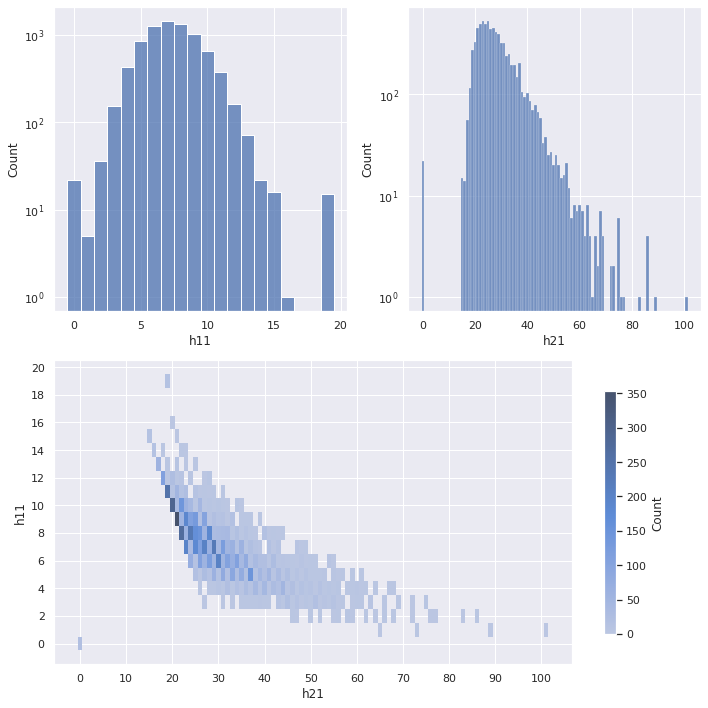

In [72]:
sns.set()
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
ax3.yaxis.set_ticks(range(0,21,2))
ax3.xaxis.set_ticks(range(0,110,10))
sns.histplot(data = df, x = 'h11', ax = ax1, log_scale = (False,True), discrete = True)
sns.histplot(data = df, x = 'h21', ax = ax2, log_scale = (False,True), discrete = True)
sns.histplot(data = df, x = 'h21', y = 'h11', cbar = True, cbar_kws = {'label':'Count','shrink':.80}, ax = ax3, discrete = True)
fig.tight_layout()

<AxesSubplot:>

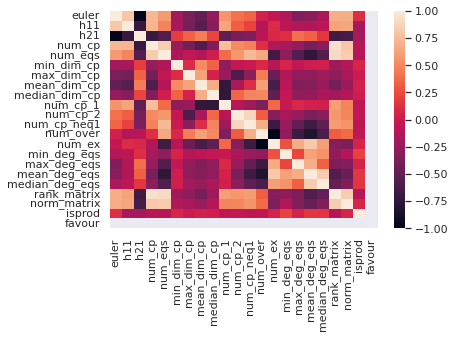

In [74]:
sns.heatmap(df.corr(), xticklabels = 1, yticklabels = 1)

In [95]:
rf = skl.ensemble.RandomForestRegressor()
fNames = ['num_cp', 'num_eqs', 'min_dim_cp', 'max_dim_cp', 'mean_dim_cp', 'median_dim_cp', 'num_cp_1', 'num_cp_2', 'num_cp_neq1', 'num_over', 'num_ex', 'min_deg_eqs', 'max_deg_eqs', 'mean_deg_eqs', 'median_deg_eqs', 'rank_matrix', 'norm_matrix']
xTrain = df[fNames]
yTrain1 = df['h11']
yTrain2 = df['h21']
fImportance = pd.DataFrame()
fImportance['feature'] = fNames
rf.fit(xTrain,yTrain1)
fImportance['h11'] = rf.feature_importances_
rf.fit(xTrain,yTrain2)
fImportance['h21'] = rf.feature_importances_

In [96]:
fImportance = pd.melt(fImportance.sort_values(by = 'h11', ascending=False), id_vars = 'feature', var_name = 'number', value_name = 'importance')

<AxesSubplot:xlabel='importance', ylabel='feature'>

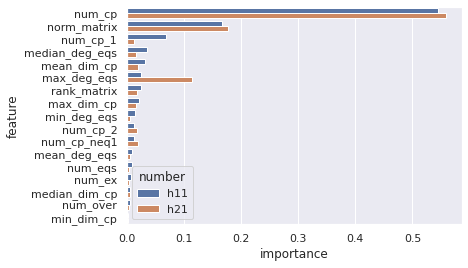

In [97]:
sns.barplot(data=fImportance, y = 'feature', x = 'importance', ci = None, hue = 'number')

# Neural Network

## Preprocessing

In [140]:
def filter_outliers(data,bounds):
    df = data.copy(deep=True)
    for i in bounds:
        df = df.loc[(df[i]>=bounds[i][0]) & (data[i]<= bounds[i][1])]
    return df

def pad_and_stack(data,size):
    ar = np.ndarray(shape=(len(data),*size))
    for i in range(len(data)):
        x = np.array(data[i+1])
        ar[i,:,:] = np.pad(x, np.subtract(size,x.shape))
    return ar

In [145]:
df['matrix']

MemoryError: Unable to allocate 58.8 GiB for an array with shape (7890, 1000, 1000) and data type float64

In [103]:
dfOut = df.loc[(df['h11'] > 0) & (df['h11'] < 17) & (df['h21'] > 0) & (df['h21'] < 92)]
from sklearn.model_selection import train_test_split
matrix_train, matrix_test, h11_train, h11_test, h21_train, h21_test = train_test_split(dfOut['matrix'], dfOut['h11'], dfOut['h21'], test_size = 0.1, shuffle = False)
matrix_train, matrix_val, h11_train, h11_val, h21_train, h21_val = train_test_split(matrixTrain, h11Train, h21Train, test_size = 1/9, shuffle = False)

NameError: name 'length' is not defined